In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [2]:
features = pd.read_csv('Features data set.csv')
sales = pd.read_csv('sales data-set.csv')
stores = pd.read_csv('stores data-set.csv')

In [3]:
features = features.drop(['IsHoliday'], axis=1)

combined = sales.merge(features, on=['Store', 'Date'])
combined = combined.merge(stores, on=['Store'])

combined.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,05/02/2010,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,12/02/2010,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,19/02/2010,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,26/02/2010,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,05/03/2010,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [4]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [5]:
combined = combined.fillna(value=0)

In [6]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     421570 non-null  float64
 8   MarkDown2     421570 non-null  float64
 9   MarkDown3     421570 non-null  float64
 10  MarkDown4     421570 non-null  float64
 11  MarkDown5     421570 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [7]:
merged_df = combined.groupby(['Store', 'Date', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
                               'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'], as_index=False).sum()

merged_df = merged_df.drop(['Dept'], axis = 1)
merged_df = merged_df.round(3)
print(merged_df.head())

   Store        Date  IsHoliday  Temperature  Fuel_Price  MarkDown1  \
0      1  01/04/2011      False        59.17       3.524       0.00   
1      1  01/06/2012      False        77.95       3.501    6086.21   
2      1  01/07/2011      False        85.55       3.524       0.00   
3      1  01/10/2010      False        71.89       2.603       0.00   
4      1  02/03/2012      False        60.96       3.630   15441.40   

   MarkDown2  MarkDown3  MarkDown4  MarkDown5      CPI  Unemployment Type  \
0        0.0       0.00       0.00       0.00  214.837         7.682    A   
1       12.0     370.51     148.75    3690.85  221.747         7.143    A   
2        0.0       0.00       0.00       0.00  215.184         7.962    A   
3        0.0       0.00       0.00       0.00  211.672         7.838    A   
4     1569.0      10.80   25390.88    8067.61  220.848         7.348    A   

     Size  Weekly_Sales  
0  151315    1495064.75  
1  151315    1624477.58  
2  151315    1488538.09  
3  151

In [8]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'], dayfirst=True)
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month

merged_df['WeekOfYear'] = merged_df['Date'].dt.isocalendar().week
merged_df['WeekOfYear'] = merged_df['WeekOfYear'].astype(np.int32)

merged_df['DayOfWeek'] = merged_df['Date'].dt.dayofweek

merged_df = merged_df.sort_values(by=['Store', 'Date'])
print(merged_df.head())

     Store       Date  IsHoliday  Temperature  Fuel_Price  MarkDown1  \
19       1 2010-02-05      False        42.31       2.572        0.0   
52       1 2010-02-12       True        38.51       2.548        0.0   
85       1 2010-02-19      False        39.93       2.514        0.0   
118      1 2010-02-26      False        46.63       2.561        0.0   
20       1 2010-03-05      False        46.50       2.625        0.0   

     MarkDown2  MarkDown3  MarkDown4  MarkDown5      CPI  Unemployment Type  \
19         0.0        0.0        0.0        0.0  211.096         8.106    A   
52         0.0        0.0        0.0        0.0  211.242         8.106    A   
85         0.0        0.0        0.0        0.0  211.289         8.106    A   
118        0.0        0.0        0.0        0.0  211.320         8.106    A   
20         0.0        0.0        0.0        0.0  211.350         8.106    A   

       Size  Weekly_Sales  Year  Month  WeekOfYear  DayOfWeek  
19   151315    1643690.90  2

In [9]:
# Initialize the Holiday_Weight column with a default value of 1
merged_df['Holiday_Weight'] = 1

# Identify specific holiday periods based on the observed data
super_bowl_week = (merged_df['Date'].dt.month == 2) & (merged_df['Date'].dt.isocalendar().week <= 6) & (merged_df['Date'].dt.dayofweek == 6)
labor_day_week = (merged_df['Date'].dt.month == 9) & (merged_df['Date'].dt.isocalendar().week == 36)

# Thanksgiving season: Weeks 47 and 48 (spike observed)
thanksgiving_week = merged_df['WeekOfYear'].isin([47, 48])

# Christmas season: Weeks 49, 50, and 51 (significant spike observed)
christmas_period = merged_df['WeekOfYear'].isin([49, 50, 51])

# Apply weights to the Holiday_Weight column
merged_df.loc[super_bowl_week, 'Holiday_Weight'] = 5
merged_df.loc[labor_day_week, 'Holiday_Weight'] = 5
merged_df.loc[thanksgiving_week, 'Holiday_Weight'] = 5
merged_df.loc[christmas_period, 'Holiday_Weight'] = 5

# Create a new column for weighted weekly sales
merged_df['Weighted_Weekly_Sales'] = merged_df['Weekly_Sales'] * merged_df['Holiday_Weight']

In [10]:
label_encoder = LabelEncoder()
merged_df['Type'] = label_encoder.fit_transform(merged_df['Type'])
merged_df.info()

csv_file_path = "merged_df.csv"
merged_df.to_csv(csv_file_path, index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 6435 entries, 19 to 6413
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Store                  6435 non-null   int64         
 1   Date                   6435 non-null   datetime64[ns]
 2   IsHoliday              6435 non-null   bool          
 3   Temperature            6435 non-null   float64       
 4   Fuel_Price             6435 non-null   float64       
 5   MarkDown1              6435 non-null   float64       
 6   MarkDown2              6435 non-null   float64       
 7   MarkDown3              6435 non-null   float64       
 8   MarkDown4              6435 non-null   float64       
 9   MarkDown5              6435 non-null   float64       
 10  CPI                    6435 non-null   float64       
 11  Unemployment           6435 non-null   float64       
 12  Type                   6435 non-null   int32         
 13  Size   

Correlation of each feature with Weighted_Weekly_Sales:
Size            0.810468
MarkDown1       0.179107
MarkDown5       0.173273
MarkDown4       0.139195
MarkDown3       0.120289
MarkDown2       0.080157
Month           0.076143
WeekOfYear      0.074211
Fuel_Price      0.009464
Year           -0.018378
Temperature    -0.063810
CPI            -0.072634
Unemployment   -0.106176
Store          -0.335332
Type           -0.598380
DayOfWeek            NaN
dtype: float64


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


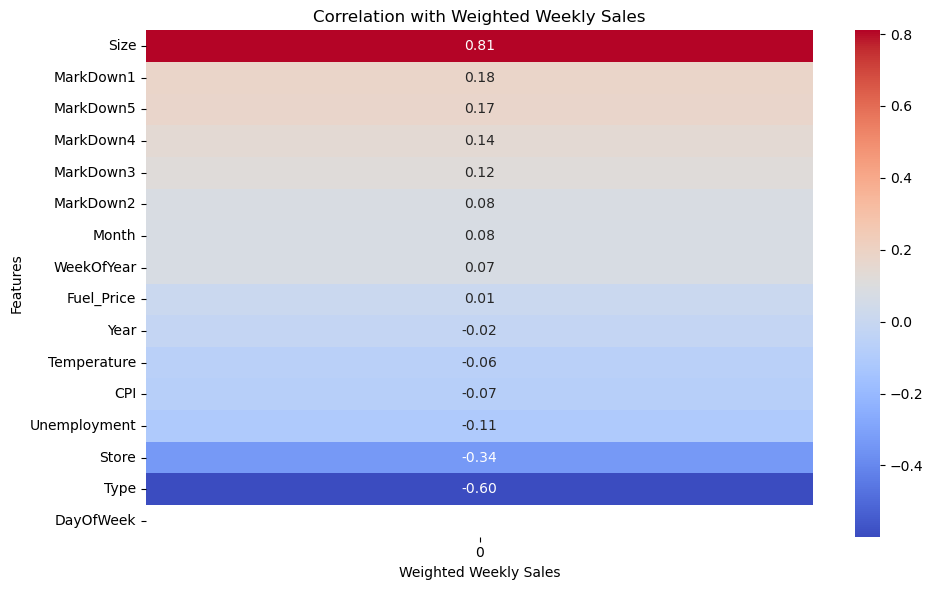

In [11]:
numeric_df = merged_df.select_dtypes(include=[np.number]).drop(columns=['Weekly_Sales', 'Weighted_Weekly_Sales', 'Holiday_Weight', ])

# Compute correlation matrix
correlation = numeric_df.corrwith(merged_df['Weekly_Sales']).sort_values(ascending=False)

print("Correlation of each feature with Weighted_Weekly_Sales:")
print(correlation)

plt.figure(figsize=(10, 6))

sns.heatmap(correlation.to_frame(), annot=True, cmap="coolwarm", cbar=True, fmt=".2f")

plt.title("Correlation with Weighted Weekly Sales")

plt.xlabel("Weighted Weekly Sales")

plt.ylabel("Features")

plt.tight_layout()

plt.show()

[0.22668357 0.15088925 0.12000745 0.1082481  0.09263525 0.08276386
 0.07737273 0.06482042 0.04500111 0.01876137 0.01281688]


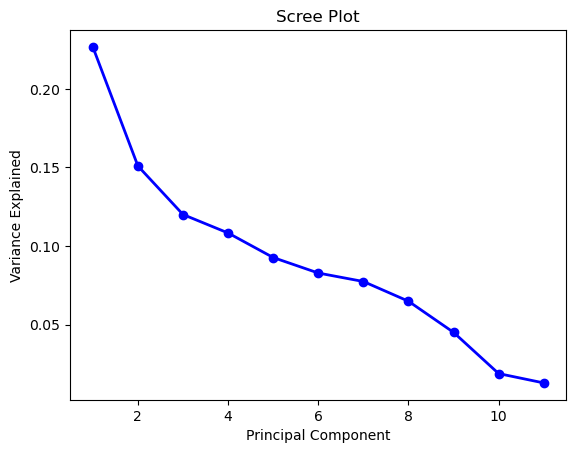

In [12]:
pca = PCA()
scaler = StandardScaler()

#making a copy to preserve the original unscaled df
combined_scaled = merged_df.copy()

#scaling each of the numerical columns
combined_scaled['Weekly_Sales'] = scaler.fit_transform(combined_scaled[['Weekly_Sales']])
combined_scaled['Temperature'] = scaler.fit_transform(combined_scaled[['Temperature']])
combined_scaled['Fuel_Price'] = scaler.fit_transform(combined_scaled[['Fuel_Price']])
combined_scaled['MarkDown1'] = scaler.fit_transform(combined_scaled[['MarkDown1']])
combined_scaled['MarkDown2'] = scaler.fit_transform(combined_scaled[['MarkDown2']])
combined_scaled['MarkDown3'] = scaler.fit_transform(combined_scaled[['MarkDown3']])
combined_scaled['MarkDown4'] = scaler.fit_transform(combined_scaled[['MarkDown4']])
combined_scaled['MarkDown5'] = scaler.fit_transform(combined_scaled[['MarkDown5']])
combined_scaled['CPI'] = scaler.fit_transform(combined_scaled[['CPI']])
combined_scaled['Unemployment'] = scaler.fit_transform(combined_scaled[['Unemployment']])
combined_scaled['Size'] = scaler.fit_transform(combined_scaled[['Size']])
combined_scaled['Weighted_Weekly_Sales'] = scaler.fit_transform(combined_scaled[['Weighted_Weekly_Sales']])
combined_scaled['Type'] = scaler.fit_transform(combined_scaled[['Type']])
combined_scaled.head()

#performing PCA on the numerical features. Which features we select will likely need tweaking
#pca.fit(combined_scaled[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Weighted_Weekly_Sales']])

pca.fit(combined_scaled[['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Type']])

print(pca.explained_variance_ratio_)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [13]:
# Define features and target variable
X = merged_df.drop(columns=['Weekly_Sales', 'Date','Weighted_Weekly_Sales'])
X['Type'] = label_encoder.fit_transform(X['Type'])

y = merged_df['Weighted_Weekly_Sales']

# Initialize and fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=123)

output  = cross_validate(rf_model, X, y, cv= 10, scoring = 'r2', return_estimator =True)

# Display feature importances for each estimator
for idx, estimator in enumerate(output['estimator']):
    print(f"Features sorted by their score for estimator {idx}:")
    feature_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': estimator.feature_importances_
    }).sort_values('importance', ascending=False)
    print(feature_importances)

Features sorted by their score for estimator 0:
           feature  importance
17  Holiday_Weight    0.622527
12            Size    0.242782
0            Store    0.038282
15      WeekOfYear    0.030236
9              CPI    0.020647
2      Temperature    0.017290
10    Unemployment    0.009545
6        MarkDown3    0.005408
3       Fuel_Price    0.004234
14           Month    0.001823
5        MarkDown2    0.001552
11            Type    0.001549
4        MarkDown1    0.001064
8        MarkDown5    0.001046
7        MarkDown4    0.000986
1        IsHoliday    0.000850
13            Year    0.000177
16       DayOfWeek    0.000000
Features sorted by their score for estimator 1:
           feature  importance
17  Holiday_Weight    0.615810
12            Size    0.252479
0            Store    0.051950
15      WeekOfYear    0.030724
2      Temperature    0.013468
9              CPI    0.010821
10    Unemployment    0.009502
3       Fuel_Price    0.004189
6        MarkDown3    0.003020
14   

In [14]:

# Define features and target variable
X = merged_df.drop(columns=['Weekly_Sales', 'Date', 'Holiday_Weight', 'Weighted_Weekly_Sales'])
X['Type'] = label_encoder.fit_transform(X['Type'])

y = merged_df['Weighted_Weekly_Sales']

# Initialize and fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=123)
rf_model.fit(X, y)

# Calculate feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances from Random Forest:")
print(feature_importances)


Feature Importances from Random Forest:
         Feature  Importance
15    WeekOfYear    0.584417
12          Size    0.241471
1      IsHoliday    0.048194
0          Store    0.038341
2    Temperature    0.026589
14         Month    0.020620
9            CPI    0.017082
10  Unemployment    0.009395
3     Fuel_Price    0.004064
6      MarkDown3    0.003095
7      MarkDown4    0.001542
5      MarkDown2    0.001480
11          Type    0.001286
8      MarkDown5    0.001236
4      MarkDown1    0.001076
13          Year    0.000113
16     DayOfWeek    0.000000


Mean Squared Error: 92001869190.69258
R-squared: 0.7144169932985673


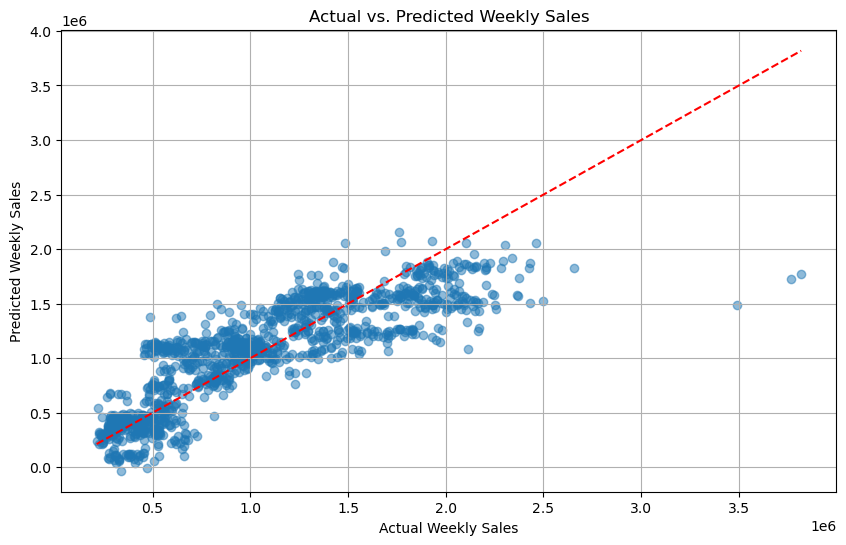

[-7.04017345e+03 -8.24205899e+04  2.54511266e+03  7.58812340e+03
  1.39246763e+00  3.59266251e+00  6.38879711e+00  2.15632520e+00
  3.64710536e+00 -1.71660994e+03 -2.05919087e+04  1.13211880e+05
  7.76210165e+00 -3.35700739e+04  7.15969544e+03 -2.87235507e+03
  8.47530285e+04]


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np


X = merged_df.drop(columns=['Date','Weekly_Sales', 'DayOfWeek', 'Weighted_Weekly_Sales'])
y = merged_df['Weekly_Sales']

label_encoder = LabelEncoder()
X['Type'] = label_encoder.fit_transform(X['Type'])
X['IsHoliday'] = label_encoder.fit_transform(X['IsHoliday'])

linear_regression_model = LinearRegression()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_regression_model.fit(x_train, y_train)
y_pred = linear_regression_model.predict(x_test)

mse =mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Actual vs. Predicted Weekly Sales")
plt.grid(True)
plt.show()


print(linear_regression_model.coef_)

In [16]:
import pandas as pd
import numpy as np
#Predict weekly sales for 2013
output_dir = 'linearRegressionStorePredictions'
os.makedirs(output_dir, exist_ok=True) 

# Load the synthetic adjusted 2013 dataset
synthetic_2013_file_path = 'synthetic_holiday_weekly_2013_adjusted_data.csv'
synthetic_2013_df = pd.read_csv(synthetic_2013_file_path)

# Output directory for predictions
output_dir = 'linearRegressionStorePredictions'
os.makedirs(output_dir, exist_ok=True)

# Ensure the 'Date' column is in datetime format
synthetic_2013_df['Date'] = pd.to_datetime(synthetic_2013_df['Date'])

# Prepare feature columns for prediction, excluding target columns
feature_columns = synthetic_2013_df.columns.drop(['Date', 'Weekly_Sales', 'DayOfWeek', 'Weighted_Weekly_Sales'])

# Ensure features like `Type` and `IsHoliday` are encoded properly
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

synthetic_2013_df['Type'] = label_encoder.fit_transform(synthetic_2013_df['Type'])
synthetic_2013_df['IsHoliday'] = label_encoder.fit_transform(synthetic_2013_df['IsHoliday'])

# Sanitize input data
def sanitize_input(input_df):
    input_df = input_df.replace([float('inf'), -float('inf')], float('nan'))  # Replace infinities with NaN
    input_df = input_df.fillna(0)  # Replace NaN with 0
    return input_df

# Prepare the sanitized feature set
X = sanitize_input(synthetic_2013_df[feature_columns])

# Predict weekly sales using the linear regression model
predicted_sales = linear_regression_model.predict(X)

# Combine predictions with dates for output
predictions_2013 = pd.DataFrame({
    'Date': synthetic_2013_df['Date'],
    'Store': synthetic_2013_df['Store'],
    'Predicted_Weekly_Sales': predicted_sales
})

predictions_2013['Predicted_Weekly_Sales'] = predictions_2013['Predicted_Weekly_Sales'].round(3)

# Save predictions to CSV
output_file = os.path.join(output_dir, 'predicted_sales_2013.csv')
predictions_2013.to_csv(output_file, index=False)

# Print completion message and show the first few rows
print(f"Predictions saved to {output_file}")
print(predictions_2013.head())

Predictions saved to linearRegressionStorePredictions\predicted_sales_2013.csv
        Date  Store  Predicted_Weekly_Sales
0 2013-01-02      1             1183349.845
1 2013-01-03      1             1150450.072
2 2013-01-09      1             1187052.284
3 2013-01-10      1             1177078.312
4 2013-01-16      1             1200373.456


Linear Regression
Mean Squared Error: 92001869190.69258
R-squared: 0.7144169932985673


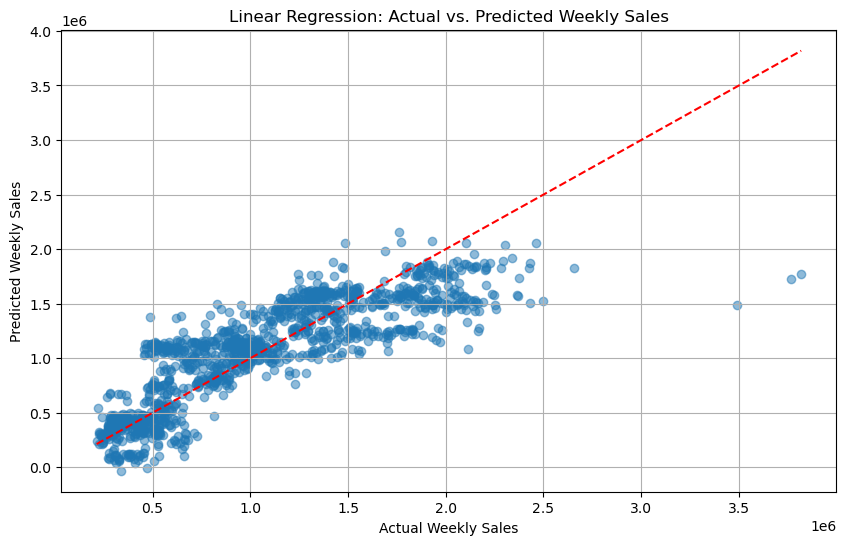

Best alpha for Lasso: 100
Lasso Regression
Mean Squared Error: 91993461644.31
R-squared: 0.71


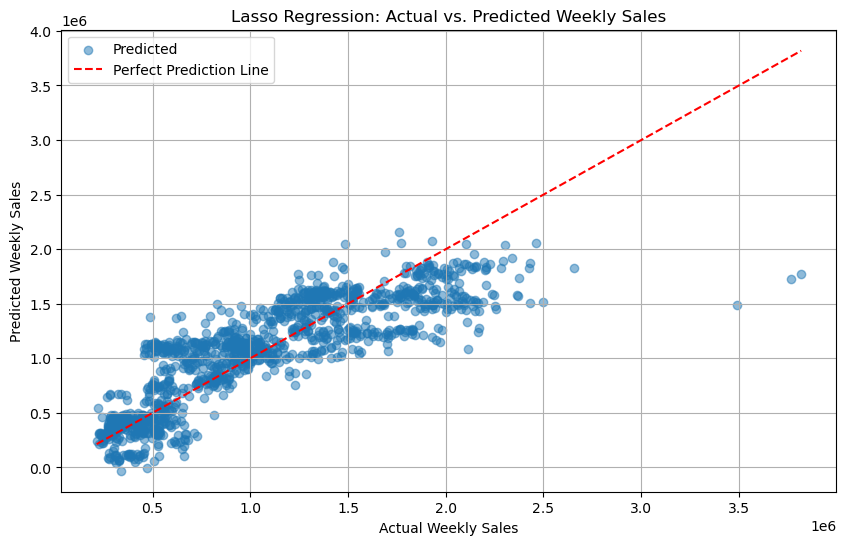

In [17]:
#lasso model
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedGroupKFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Prepare data for Linear Regression and Lasso Regression
X_lr_lasso = merged_df.drop(columns=['Date', 'Weekly_Sales', 'DayOfWeek', 'Weighted_Weekly_Sales'])
y_lr_lasso = merged_df['Weekly_Sales']

label_encoder = LabelEncoder()
X_lr_lasso['Type'] = label_encoder.fit_transform(X_lr_lasso['Type'])
X_lr_lasso['IsHoliday'] = label_encoder.fit_transform(X_lr_lasso['IsHoliday'])

scaler = StandardScaler()
X_lr_lasso_scaled = scaler.fit_transform(X_lr_lasso)

# Splitting the data
x_train_lr_lasso, x_test_lr_lasso, y_train_lr_lasso, y_test_lr_lasso = train_test_split(
    X_lr_lasso, y_lr_lasso, test_size=0.2, random_state=42
)

### Linear Regression
linear_regression_model = LinearRegression()
linear_regression_model.fit(x_train_lr_lasso, y_train_lr_lasso)
y_pred_lr = linear_regression_model.predict(x_test_lr_lasso)

mse_lr = mean_squared_error(y_test_lr_lasso, y_pred_lr)
r2_lr = r2_score(y_test_lr_lasso, y_pred_lr)

print("Linear Regression")
print(f"Mean Squared Error: {mse_lr}")
print(f"R-squared: {r2_lr}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_lr_lasso, y_pred_lr, alpha=0.5)
plt.plot([y_test_lr_lasso.min(), y_test_lr_lasso.max()], [y_test_lr_lasso.min(), y_test_lr_lasso.max()], 'r--')
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Linear Regression: Actual vs. Predicted Weekly Sales")
plt.grid(True)
plt.show()

### Lasso Regression with Grid Search
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(scaler.fit_transform(x_train_lr_lasso), y_train_lr_lasso)

# Retrieve the best alpha
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha for Lasso: {best_alpha}")

# Train Lasso model with the best alpha
lasso = Lasso(alpha=best_alpha, max_iter=10000)
lasso.fit(scaler.fit_transform(x_train_lr_lasso), y_train_lr_lasso)

# Predict on the test set
y_pred_lasso = lasso.predict(scaler.transform(x_test_lr_lasso))

# Evaluate the model
mse_lasso = mean_squared_error(y_test_lr_lasso, y_pred_lasso)
r2_lasso = r2_score(y_test_lr_lasso, y_pred_lasso)

print("Lasso Regression")
print(f"Mean Squared Error: {mse_lasso:.2f}")
print(f"R-squared: {r2_lasso:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_lr_lasso, y_pred_lasso, alpha=0.5, label="Predicted")
plt.plot([y_test_lr_lasso.min(), y_test_lr_lasso.max()], [y_test_lr_lasso.min(), y_test_lr_lasso.max()], 'r--', label="Perfect Prediction Line")
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Lasso Regression: Actual vs. Predicted Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

DBSCAN with eps=0.5: Silhouette Score = 0.089
DBSCAN with eps=1.0: Silhouette Score = 0.108
DBSCAN with eps=1.5: Silhouette Score = 0.317
DBSCAN with eps=2.0: Silhouette Score = 0.358

Best eps value based on Silhouette Score: 2.0
Best Silhouette Score: 0.358
Number of clusters: 2
Number of noise points: 0


C:\Users\mm3le\AppData\Local\Temp\ipykernel_21296\3289807036.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_dbscan['Cluster'] = final_labels


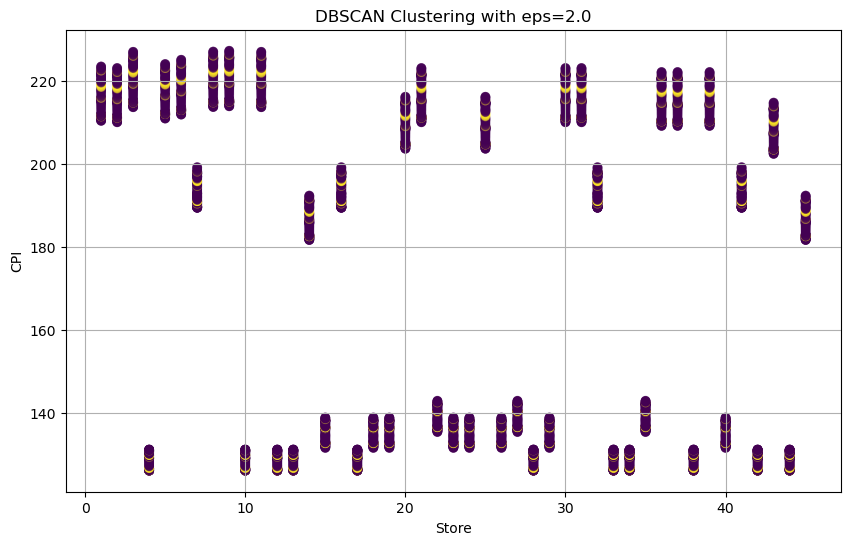

In [28]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Prepare data for DBSCAN
X_dbscan = merged_df[['Holiday_Weight', 'Size', 'Store', 'WeekOfYear', 'CPI', 'Temperature', 'Unemployment']]

scaler = StandardScaler()
X_dbscan_scaled = scaler.fit_transform(X_dbscan)

# Perform DBSCAN clustering
eps_values = [0.5, 1.0, 1.5, 2.0]  # Try different epsilon values
min_samples = 5  # Minimum number of points in a neighborhood to form a cluster
best_silhouette_score = -1  # Initialize the best silhouette score

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_dbscan_scaled)
    
    # Silhouette Score (only calculate if there are more than 1 cluster)
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(X_dbscan_scaled, labels)
        print(f"DBSCAN with eps={eps}: Silhouette Score = {silhouette_avg:.3f}")
        
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_eps = eps
            best_labels = labels
    else:
        print(f"DBSCAN with eps={eps}: Only one cluster or noise points detected.")

# Output the best epsilon value
print(f"\nBest eps value based on Silhouette Score: {best_eps}")
print(f"Best Silhouette Score: {best_silhouette_score:.3f}")

# Final DBSCAN with the best eps
dbscan = DBSCAN(eps=best_eps, min_samples=min_samples)
final_labels = dbscan.fit_predict(X_dbscan_scaled)

# Add the cluster assignments to the original dataset
X_dbscan['Cluster'] = final_labels

# Print the number of clusters and noise points
n_clusters = len(set(final_labels)) - (1 if -1 in final_labels else 0)  # Exclude noise points (-1 label)
n_noise = list(final_labels).count(-1)
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

# Visualize the clusters (optional, select two features to plot)
plt.figure(figsize=(10, 6))
plt.scatter(X_dbscan['Store'], X_dbscan['CPI'], c=final_labels, cmap='viridis', alpha=0.5)
plt.xlabel("Store")
plt.ylabel("CPI")
plt.title(f"DBSCAN Clustering with eps={best_eps}")
plt.grid(True)
plt.show()

In [19]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6435 entries, 19 to 6413
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Store                  6435 non-null   int64         
 1   Date                   6435 non-null   datetime64[ns]
 2   IsHoliday              6435 non-null   bool          
 3   Temperature            6435 non-null   float64       
 4   Fuel_Price             6435 non-null   float64       
 5   MarkDown1              6435 non-null   float64       
 6   MarkDown2              6435 non-null   float64       
 7   MarkDown3              6435 non-null   float64       
 8   MarkDown4              6435 non-null   float64       
 9   MarkDown5              6435 non-null   float64       
 10  CPI                    6435 non-null   float64       
 11  Unemployment           6435 non-null   float64       
 12  Type                   6435 non-null   int32         
 13  Size   

Mean Squared Error: 998834724603.878
R-squared: 0.7477489609047407


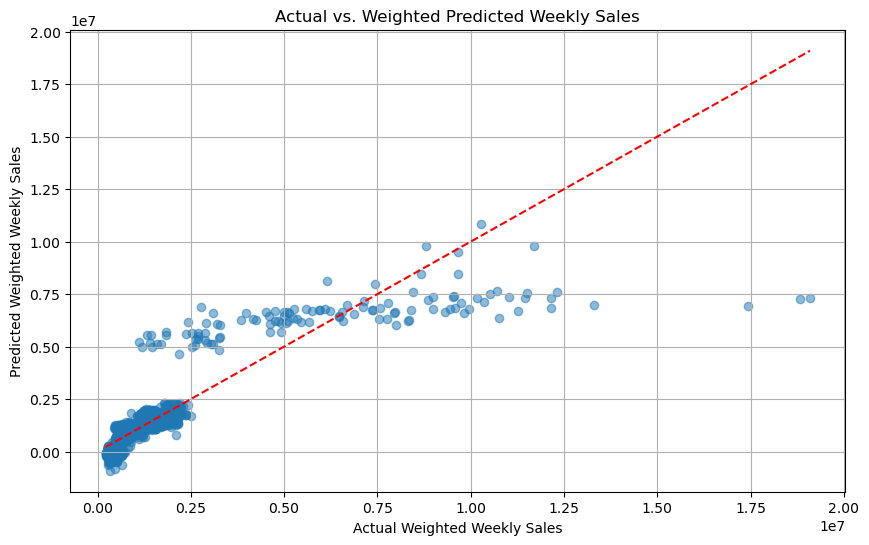

[-1.03603115e+04 -4.23399340e+05  3.86601832e+02  4.81573069e+04
 -2.09188176e+00  1.68597776e+00  4.45421054e+01  3.88879410e+00
  1.06102587e+01 -2.52835361e+03 -3.62641655e+04  1.93962668e+05
  1.16007131e+01 -9.18663609e+04 -1.95284770e+05  4.49234348e+04
  1.36194640e+06]


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
#Predicted weighted_weekly_sales for the year. 

X = merged_df.drop(columns=['Date', 'Weekly_Sales', 'DayOfWeek', 'Weighted_Weekly_Sales'])
y = merged_df['Weighted_Weekly_Sales']

label_encoder = LabelEncoder()
X['Type'] = label_encoder.fit_transform(X['Type'])

linear_regression_model = LinearRegression()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_regression_model.fit(x_train, y_train)
y_pred = linear_regression_model.predict(x_test)

mse =mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
plt.xlabel("Actual Weighted Weekly Sales")
plt.ylabel("Predicted Weighted Weekly Sales")
plt.title("Actual vs. Weighted Predicted Weekly Sales")
plt.grid(True)
plt.show()


print(linear_regression_model.coef_)

C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 1879127746816.1152
Correlation: 0.6952382924116783


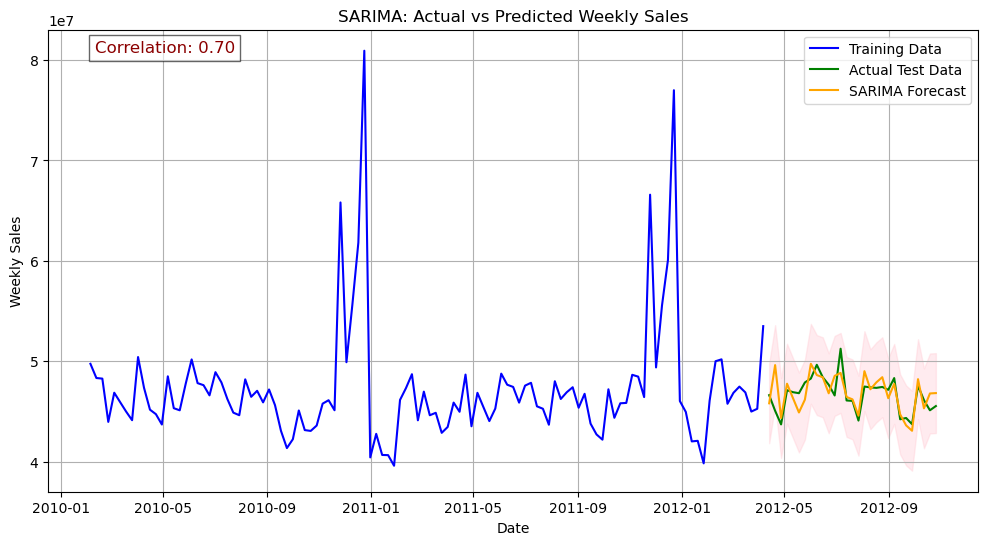

In [21]:

store_df = merged_df[['Date', 'Weekly_Sales', 'Weighted_Weekly_Sales']]
store_df = store_df.reset_index(drop=True)


unweighted_store_df = store_df[['Date', 'Weekly_Sales']]
unweighted_store_df = unweighted_store_df.groupby('Date', as_index=False)['Weekly_Sales'].sum()

unweighted_store_df.set_index('Date', inplace=True)

unweighted_store_df.head()

y = unweighted_store_df['Weekly_Sales']

train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]


sarima_order = (1, 0, 1)
seasonal_order = (1, 1, 1, 52)  # Assuming weekly seasonality (adjust if needed)


model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = model.fit(disp=False)


forecast = sarima_fit.get_forecast(steps=len(y_test))
y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()


mse = mean_squared_error(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0, 1]  # Correlation coefficient

print(f"Mean Squared Error: {mse}")
print(f"Correlation: {correlation}")


plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(y_train.index, y_train, label='Training Data', color='blue')

# Plot actual test data
plt.plot(y_test.index, y_test, label='Actual Test Data', color='green')

# Plot predictions
plt.plot(y_test.index, y_pred, label='SARIMA Forecast', color='orange')


plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('SARIMA: Actual vs Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)

# Add correlation as text to the plot
plt.text(x=0.05, y=0.95, s=f"Correlation: {correlation:.2f}", fontsize=12,
         transform=plt.gca().transAxes, color='darkred', bbox=dict(facecolor='white', alpha=0.6))

plt.show()


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 2568567626235.0415
Correlation: 0.999284938586232


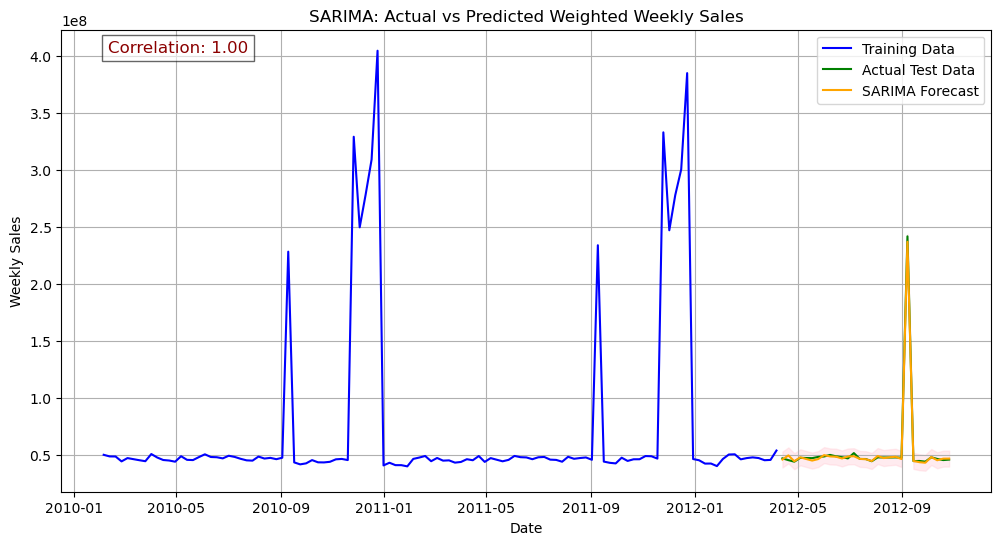

In [22]:

store_df = merged_df[['Date', 'Weekly_Sales', 'Weighted_Weekly_Sales']]
store_df = store_df.reset_index(drop=True)

weighted_store_df = store_df[['Date', 'Weighted_Weekly_Sales']]
weighted_store_df = weighted_store_df.groupby('Date', as_index=False)['Weighted_Weekly_Sales'].sum()

weighted_store_df.set_index('Date', inplace=True)

weighted_store_df.head()

y = weighted_store_df['Weighted_Weekly_Sales']

train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]


sarima_order = (1, 0, 1)
seasonal_order = (1, 1, 1, 52)  # Assuming weekly seasonality (adjust if needed)


model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = model.fit(disp=False)


forecast = sarima_fit.get_forecast(steps=len(y_test))
y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()


mse = mean_squared_error(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0, 1]  # Correlation coefficient

print(f"Mean Squared Error: {mse}")
print(f"Correlation: {correlation}")


plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(y_train.index, y_train, label='Training Data', color='blue')

# Plot actual test data
plt.plot(y_test.index, y_test, label='Actual Test Data', color='green')

# Plot predictions
plt.plot(y_test.index, y_pred, label='SARIMA Forecast', color='orange')


plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('SARIMA: Actual vs Predicted Weighted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)

# Add correlation as text to the plot
plt.text(x=0.05, y=0.95, s=f"Correlation: {correlation:.2f}", fontsize=12,
         transform=plt.gca().transAxes, color='darkred', bbox=dict(facecolor='white', alpha=0.6))

plt.show()


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a s

Mean Squared Error: 87808497784.33241
Correlation: 0.8386914610615275


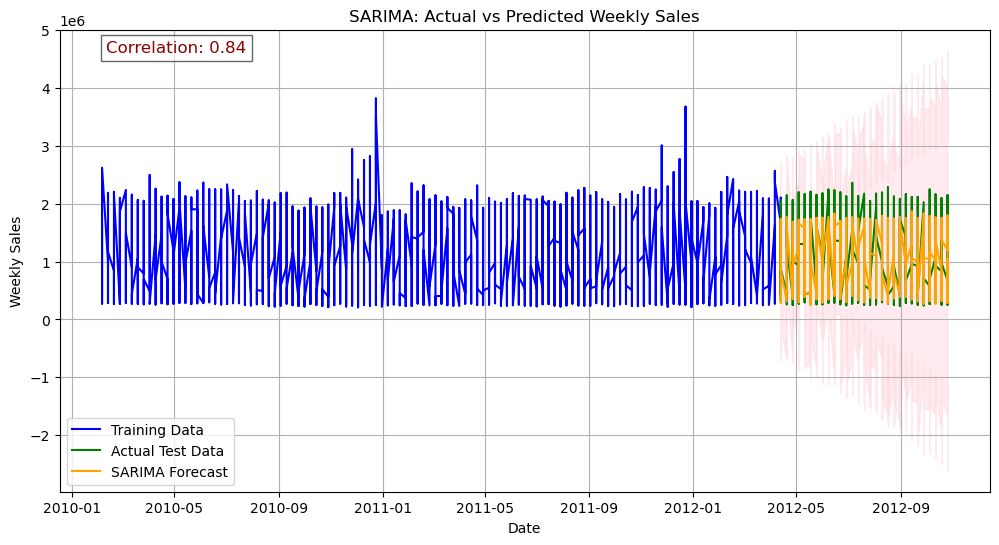

In [23]:
#Test with using multiple variables


unweighted_store_df = merged_df.copy()
unweighted_store_df.sort_values(by='Date', inplace=True)

unweighted_store_df.set_index('Date', inplace=True)

unweighted_store_df.head()

y = unweighted_store_df['Weekly_Sales']

train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]


sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 52)  # Assuming weekly seasonality (adjust if needed)

exog = unweighted_store_df[['Size']]
exog_train, exog_test = exog[:train_size], exog[train_size:]


model = SARIMAX(y_train, exog=exog_train, order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = model.fit(disp=False)



forecast = sarima_fit.get_forecast(steps=len(y_test), exog=exog_test)
y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()


mse = mean_squared_error(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0, 1]  # Correlation coefficient

print(f"Mean Squared Error: {mse}")
print(f"Correlation: {correlation}")


plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(y_train.index, y_train, label='Training Data', color='blue')

# Plot actual test data
plt.plot(y_test.index, y_test, label='Actual Test Data', color='green')

# Plot predictions
plt.plot(y_test.index, y_pred, label='SARIMA Forecast', color='orange')


plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('SARIMA: Actual vs Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)

# Add correlation as text to the plot
plt.text(x=0.05, y=0.95, s=f"Correlation: {correlation:.2f}", fontsize=12,
         transform=plt.gca().transAxes, color='darkred', bbox=dict(facecolor='white', alpha=0.6))

plt.show()


            Weekly_Sales    Size
Date                            
2010-02-05   49750740.50  151315
2010-02-12   48336677.63  151315
2010-02-19   48276993.78  151315
2010-02-26   43968571.13  151315
2010-03-05   46871470.30  151315


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 36420899752058.42
Correlation: 0.7094381527491729


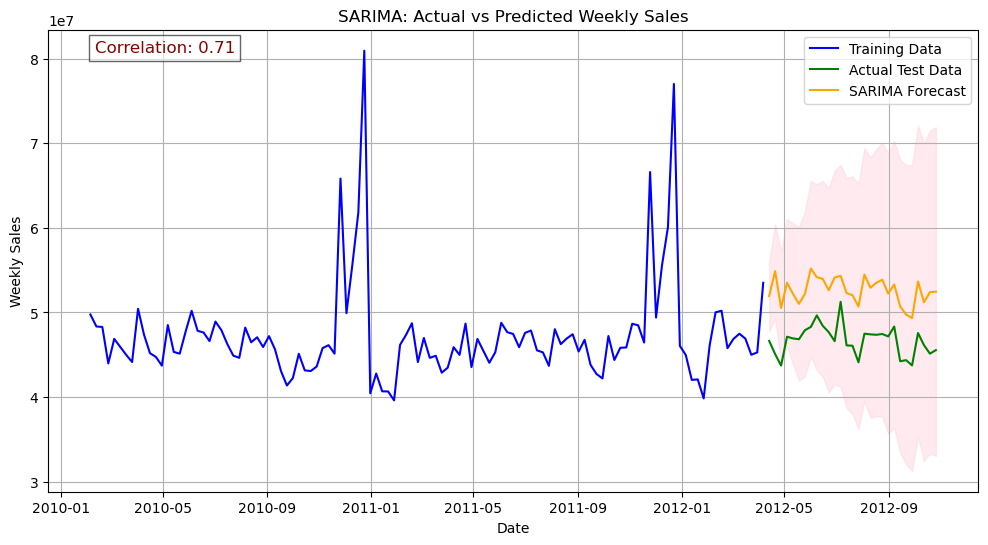

In [24]:
# Drop the 'Weighted_Weekly_Sales' column (if applicable) and sort by date
new_unweighted_store_df = merged_df.copy()

new_unweighted_store_df.reset_index

# Group by 'Date' and apply custom aggregation
new_unweighted_store_df = new_unweighted_store_df.groupby('Date', as_index=False).agg({
    'Weekly_Sales': 'sum',  # Sum Weekly Sales
    'Size': 'first',         # Use the first Size value for each group (or replace with 'mean', 'mode', etc.)
})

# Sort and set 'Date' as the index
new_unweighted_store_df.set_index('Date', inplace=True)

# Verify the results
print(new_unweighted_store_df.head())

# Extract the target variable (y) and exogenous variable (Size)
y = new_unweighted_store_df['Weekly_Sales']
exog = new_unweighted_store_df[['Size']]

# Split data into training and testing sets
train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]

# Fit the SARIMAX model
model = SARIMAX(y_train, exog=exog_train, order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = model.fit(disp=False)

# Forecasting
forecast = sarima_fit.get_forecast(steps=len(y_test), exog=exog_test)
y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0, 1]

print(f"Mean Squared Error: {mse}")
print(f"Correlation: {correlation}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Training Data', color='blue')
plt.plot(y_test.index, y_test, label='Actual Test Data', color='green')
plt.plot(y_test.index, y_pred, label='SARIMA Forecast', color='orange')
plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA: Actual vs Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.text(
    x=0.05, y=0.95, s=f"Correlation: {correlation:.2f}", fontsize=12,
    transform=plt.gca().transAxes, color='darkred', bbox=dict(facecolor='white', alpha=0.6)
)
plt.show()

In [25]:
output_dir = 'storePredictions'
os.makedirs(output_dir, exist_ok=True)

store_df = merged_df[['Date', 'Store', 'Weekly_Sales', 'Weighted_Weekly_Sales']]
store_df = store_df.reset_index(drop=True)


unweighted_store_df = store_df[['Date', 'Store', 'Weekly_Sales']]

unweighted_store_df['Store'].unique()

for store_id in unweighted_store_df['Store'].unique():

    unweighted_df = unweighted_store_df.loc[unweighted_store_df['Store'] == store_id]
    unweighted_df = unweighted_df[['Date', 'Weekly_Sales']]

    unweighted_df.set_index('Date', inplace=True)

    y = unweighted_df['Weekly_Sales']

    train_size = int(len(y) * 0.8)
    y_train, y_test = y[:train_size], y[train_size:]


    sarima_order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 52)  # Assuming weekly seasonality (adjust if needed)


    model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order)
    sarima_fit = model.fit(disp=False)


    forecast = sarima_fit.get_forecast(steps=len(y_test))
    y_pred = forecast.predicted_mean
    conf_int = forecast.conf_int()


    mse = mean_squared_error(y_test, y_pred)
    correlation = np.corrcoef(y_test, y_pred)[0, 1]  # Correlation coefficient

    print(f"Mean Squared Error: {mse}")
    print(f"Correlation: {correlation}")


    plt.figure(figsize=(12, 6))

    # Plot training data
    plt.plot(y_train.index, y_train, label='Training Data', color='blue')

    # Plot actual test data
    plt.plot(y_test.index, y_test, label='Actual Test Data', color='green')

    # Plot predictions
    plt.plot(y_test.index, y_pred, label='SARIMA Forecast', color='orange')


    plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

    plt.title('SARIMA: Actual vs Predicted Weekly Sales')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.grid(True)

    # Add correlation as text to the plot
    plt.text(x=0.05, y=0.95, s=f"Correlation: {correlation:.2f}", fontsize=12,
            transform=plt.gca().transAxes, color='darkred', bbox=dict(facecolor='white', alpha=0.6))

    
    filename = os.path.join(output_dir, f'Store_{store_id}_Forecasting.png')
    plt.savefig(filename)
    plt.close()





C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

Mean Squared Error: 44069037962.47603
Correlation: 0.7582454989899509


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 29303767043.365738
Correlation: 0.5969813020496781


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 3895388188.082693
Correlation: 0.5995276373621967


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 76054705461.78836
Correlation: 0.503979437746182


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 2995141172.274576
Correlation: 0.7005957485607354


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

Mean Squared Error: 51551135333.38527
Correlation: 0.80121256263138


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 10640806888.75751
Correlation: 0.9359967469073279


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

Mean Squared Error: 4740366492.51616
Correlation: 0.5030929178539613


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 7456706436.697926
Correlation: 0.650585350012535


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 62782763390.3425
Correlation: 0.47147911497769085


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 41164707727.18361
Correlation: 0.4673759126473725


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 8540532442.563392
Correlation: 0.8115487261953688


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 74805969002.72537
Correlation: 0.3032015600677018


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 243945811726.343
Correlation: 0.5372040337810321


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 5592839135.27174
Correlation: 0.7113376413764833


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 2360446392.317081
Correlation: 0.9192594919036311


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 8301382092.225899
Correlation: 0.9163813586873689


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 14223142299.109167
Correlation: 0.36878717828675694


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 44374393887.97411
Correlation: 0.6712176842390959


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 174448281958.60687
Correlation: 0.3805992935451737


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 4272535001.5666156
Correlation: 0.7004682611390356


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 28113791790.84903
Correlation: 0.6931198866764843


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 50326664983.33266
Correlation: 0.7601633694298578


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 30759424432.992123
Correlation: 0.7954204235440173


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 13243158756.534664
Correlation: 0.4911389253010357


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 10888772827.097494
Correlation: 0.8354744273720643


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 28731029522.002316
Correlation: 0.8106670111764682


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 20913655923.966286
Correlation: 0.7444739369843156


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 8077270289.682352
Correlation: 0.7093018473901647


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 451959045.7426393
Correlation: 0.23650961728749173


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 7960321580.161158
Correlation: 0.7258530000938168


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 17228235881.731377
Correlation: 0.49753136235881695


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

Mean Squared Error: 267733382.60693046
Correlation: 0.8299594079936717


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

Mean Squared Error: 5990062077.876537
Correlation: 0.5838557883819537


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 3784339180.161188
Correlation: 0.4680654201332811


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 829426905.4165915
Correlation: 0.7795471078163407


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 533861387.1065572
Correlation: 0.23679736775540416


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

Mean Squared Error: 3102408837.228715
Correlation: 0.6277513720506749


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 91392709876.95851
Correlation: 0.6089686353485871


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 17876975058.967422
Correlation: 0.8492067041144405


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 17346333654.77729
Correlation: 0.7460250445561012


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

Mean Squared Error: 1100824222.3253036
Correlation: 0.8174142249881687


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 490857538.9635778
Correlation: 0.8026196716480711


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 193111262.0815548
Correlation: 0.3833933185530748


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 14762879966.09699
Correlation: 0.6158236368429792


In [26]:
output_dir = 'weightedStorePredictions'
os.makedirs(output_dir, exist_ok=True)

store_df = merged_df[['Date', 'Store', 'Weekly_Sales', 'Weighted_Weekly_Sales']]
store_df = store_df.reset_index(drop=True)


weighted_store_df = store_df[['Date', 'Store', 'Weighted_Weekly_Sales']]

weighted_store_df['Store'].unique()

for store_id in weighted_store_df['Store'].unique():

    weighted_df = weighted_store_df.loc[weighted_store_df['Store'] == store_id]
    weighted_df = weighted_df[['Date', 'Weighted_Weekly_Sales']]

    weighted_df.set_index('Date', inplace=True)

    y = weighted_df['Weighted_Weekly_Sales']

    train_size = int(len(y) * 0.8)
    y_train, y_test = y[:train_size], y[train_size:]


    sarima_order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 52)  # Assuming weekly seasonality (adjust if needed)


    model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order)
    sarima_fit = model.fit(disp=False)


    forecast = sarima_fit.get_forecast(steps=len(y_test))
    y_pred = forecast.predicted_mean
    conf_int = forecast.conf_int()


    mse = mean_squared_error(y_test, y_pred)
    correlation = np.corrcoef(y_test, y_pred)[0, 1]  # Correlation coefficient

    print(f"Mean Squared Error: {mse}")
    print(f"Correlation: {correlation}")


    plt.figure(figsize=(12, 6))

    # Plot training data
    plt.plot(y_train.index, y_train, label='Training Data', color='blue')

    # Plot actual test data
    plt.plot(y_test.index, y_test, label='Actual Test Data', color='green')

    # Plot predictions
    plt.plot(y_test.index, y_pred, label='SARIMA Forecast', color='orange')


    plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

    plt.title('SARIMA: Actual vs Predicted Weekly Sales')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.grid(True)

    # Add correlation as text to the plot
    plt.text(x=0.05, y=0.95, s=f"Correlation: {correlation:.2f}", fontsize=12,
            transform=plt.gca().transAxes, color='darkred', bbox=dict(facecolor='white', alpha=0.6))

    
    filename = os.path.join(output_dir, f'Store_{store_id}_Forecasting.png')
    plt.savefig(filename)
    plt.close()





C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 38177689101.34101
Correlation: 0.9989166901197317


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 42944624601.7874
Correlation: 0.9986682679321895


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 2870447952.549092
Correlation: 0.9986749358517101


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 72736797762.62154
Correlation: 0.9988189789275208


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 3010502925.6883597
Correlation: 0.9987584702560616


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 51734550388.46216
Correlation: 0.9983029763958445


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 10449119866.296318
Correlation: 0.997207791251413


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 9646392038.508488
Correlation: 0.9985797554823889


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 7272296274.183321
Correlation: 0.9987260816848064


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 37759884461.29313
Correlation: 0.9971957650926844


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 33425521830.356346
Correlation: 0.9972177160877038


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

Mean Squared Error: 7239138199.20964
Correlation: 0.9989076257492463


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 116143137005.95888
Correlation: 0.9984736640704058


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 282520919724.4437
Correlation: 0.9941388271566081


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 5912798913.553224
Correlation: 0.9971030283318703


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 4795372307.706627
Correlation: 0.9977716832192247


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 9841953894.11231
Correlation: 0.9993848577420285


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 30850822410.491444
Correlation: 0.9880650489663246


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 37547214957.17552
Correlation: 0.9983641471264


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 137997011638.30447
Correlation: 0.9969694267691527


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 4637710489.488184
Correlation: 0.9967472235369669


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 25556575393.83274
Correlation: 0.9975085212593446


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 54931901637.07343
Correlation: 0.9973185282587766


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 30815571156.708256
Correlation: 0.9984048243213706


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\ML

Mean Squared Error: 14967371829.106287
Correlation: 0.9976041118645708


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 10467910920.083908
Correlation: 0.9987995723025157


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 43749234821.41955
Correlation: 0.9982896166026913


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 48929038861.37758
Correlation: 0.9967792253603107


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 8769430273.953213
Correlation: 0.9970799720618275


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 5402485388.711154
Correlation: 0.9979936864143613


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting param

Mean Squared Error: 7031710343.472568
Correlation: 0.9994385350432501


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 16951030454.445423
Correlation: 0.9988946123763536


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 283090068.8455151
Correlation: 0.9987056329307454


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 5729202104.112691
Correlation: 0.9990002896724324


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 11437730313.92012
Correlation: 0.9970797498120415


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 1671467070.945403
Correlation: 0.9982544821441621


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 668954347.6738435
Correlation: 0.9990283520382298


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 5574560221.938213
Correlation: 0.9974423065377704


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 71676687440.36275
Correlation: 0.9978725235017477


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 18846263205.330517
Correlation: 0.998894492182909


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 18917452945.22555
Correlation: 0.9987746994909548


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 1087539883.8062682
Correlation: 0.9981873979723854


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

Mean Squared Error: 940575931.0821389
Correlation: 0.9990128366392229


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 1423925593.0188258
Correlation: 0.9986393443176838


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 15232956388.918407
Correlation: 0.9976105617654767


C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\ProgramData\miniconda3\envs\MLProject\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


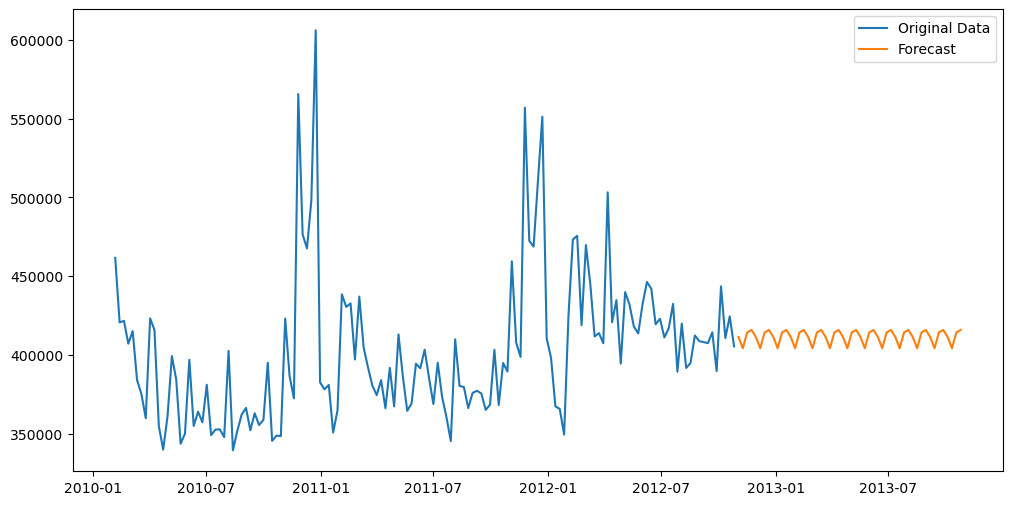

In [27]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

store_df = merged_df[['Date', 'Store', 'Weekly_Sales', 'Weighted_Weekly_Sales']]


unweighted_store_df = store_df[['Date', 'Store', 'Weekly_Sales']]
unweighted_store_df = merged_df.loc[weighted_store_df['Store'] == 3]

unweighted_store_df = unweighted_store_df.set_index('Date')


model = ExponentialSmoothing(unweighted_store_df['Weekly_Sales'], seasonal='mul', seasonal_periods=4)

fit = model.fit()

#Make predictions for the next 3 periods
forecast = fit.forecast(52)

#Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(unweighted_store_df['Weekly_Sales'], label='Original Data')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()